## Loading libraries & dataset 

In [23]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_score, recall_score, roc_curve
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_path = r"C:\Users\Saket\Desktop\ML\Loan Default Prediction Model\data\Loan_Default.csv"
df = pd.read_csv(data_path)

# Initial data exploration
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Dataset shape: (148670, 34)

First 5 rows:
      ID  year loan_limit             Gender approv_in_adv loan_type  \
0  24890  2019         cf  Sex Not Available         nopre     type1   
1  24891  2019         cf               Male         nopre     type2   
2  24892  2019         cf               Male           pre     type1   
3  24893  2019         cf               Male         nopre     type1   
4  24894  2019         cf              Joint           pre     type1   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  ...  \
0           p1                l1        nopc                  nob/c  ...   
1           p1                l1        nopc                    b/c  ...   
2           p1                l1        nopc                  nob/c  ...   
3           p4                l1        nopc                  nob/c  ...   
4           p1                l1        nopc                  nob/c  ...   

   credit_type  Credit_Score  co-applicant_credit_type    age  \
0 

In [5]:
print("\nDataset info:")
print(df.info())


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charge

In [6]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
ID                               0
year                             0
loan_limit                    3344
Gender                           0
approv_in_adv                  908
loan_type                        0
loan_purpose                   134
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              39642
term                            41
Neg_ammortization              121
interest_only                    0
lump_sum_payment                 0
property_value               15098
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        9150
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
sub

## Exploratory Data Analysis (EDA)

In [8]:
# 'Status'(1 = Default, 0 = No Default)
target_column = 'Status'
print("Target variable distribution:")
print(df[target_column].value_counts())
print(f"Default rate: {df[target_column].mean():.4f}")

features_to_drop = ['ID']
df_clean = df.drop(columns=features_to_drop)

numerical_features = ['year', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 
                     'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'dtir1']

categorical_features = ['loan_limit', 'Gender', 'approv_in_adv', 'loan_type', 'loan_purpose', 
                       'Credit_Worthiness', 'open_credit', 'business_or_commercial', 'Neg_ammortization',
                       'interest_only', 'lump_sum_payment', 'construction_type', 'occupancy_type',
                       'Secured_by', 'total_units', 'credit_type', 'co-applicant_credit_type', 
                       'age', 'submission_of_application', 'Region', 'Security_Type']

print(f"\nNumerical features: {len(numerical_features)}")
print(f"Categorical features: {len(categorical_features)}")


Target variable distribution:
Status
0    112031
1     36639
Name: count, dtype: int64
Default rate: 0.2464

Numerical features: 11
Categorical features: 21


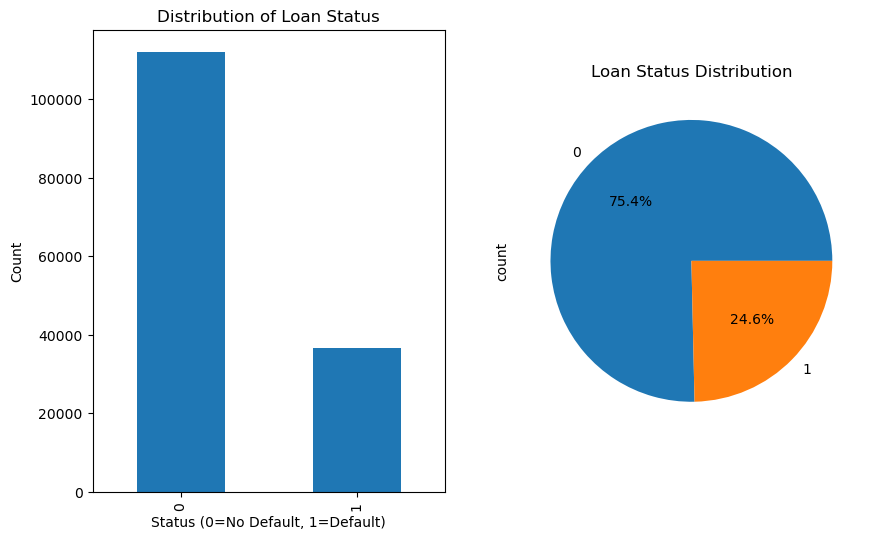

In [9]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
df[target_column].value_counts().plot(kind='bar')
plt.title('Distribution of Loan Status')
plt.xlabel('Status (0=No Default, 1=Default)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df[target_column].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Loan Status Distribution')
plt.show()

## Data Preprocessing

### Handling missing features using Imputation

In [10]:
df_processed = df_clean.copy()

# numerical features - use median imputation
numerical_imputer = SimpleImputer(strategy='median')
df_processed[numerical_features] = numerical_imputer.fit_transform(df_processed[numerical_features])

# Handle categorical features - use mode imputation
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_processed[categorical_features] = categorical_imputer.fit_transform(df_processed[categorical_features])

print(f"Missing values after imputation: {df_processed.isnull().sum().sum()}")

Missing values after imputation: 0


### Encoding categories for Random Forest

In [11]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_processed, columns=categorical_features, drop_first=True)

print(f"Dataset shape after encoding: {df_encoded.shape}")
print(f"Features increased from {len(numerical_features) + len(categorical_features)} to {df_encoded.shape[1] - 1}")

# Display some of the new encoded columns
print("\nSample of encoded columns:")
print(df_encoded.columns[:20].tolist())

Dataset shape after encoding: (148670, 50)
Features increased from 32 to 49

Sample of encoded columns:
['year', 'loan_amount', 'rate_of_interest', 'Interest_rate_spread', 'Upfront_charges', 'term', 'property_value', 'income', 'Credit_Score', 'LTV', 'Status', 'dtir1', 'loan_limit_ncf', 'Gender_Joint', 'Gender_Male', 'Gender_Sex Not Available', 'approv_in_adv_pre', 'loan_type_type2', 'loan_type_type3', 'loan_purpose_p2']


## Feature Selection

### Calculating correlation between features

In [13]:
X = df_encoded.drop(target_column, axis=1)
y = df_encoded[target_column]

print(f"Total features before selection: {X.shape[1]}")

correlations = X.corrwith(y).abs()
high_corr_features = correlations[correlations > 0.1].index.tolist()

print(f"Features with correlation > 0.1: {len(high_corr_features)}")
print("\nTop 10 correlated features:")
print(correlations.sort_values(ascending=False).head(10))

Total features before selection: 49
Features with correlation > 0.1: 7

Top 10 correlated features:
credit_type_EQUI                     0.592168
lump_sum_payment_not_lpsm            0.187752
Neg_ammortization_not_neg            0.155835
co-applicant_credit_type_EXP         0.144239
credit_type_CRIF                     0.126332
credit_type_EXP                      0.124660
submission_of_application_to_inst    0.122410
Upfront_charges                      0.095094
loan_type_type2                      0.092550
business_or_commercial_nob/c         0.092550
dtype: float64


### Training baseline Random Forest for feature importance

In [14]:
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_baseline.fit(X, y)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_baseline.feature_importances_
}).sort_values('importance', ascending=False)

top_important_features = feature_importance.head(20)['feature'].tolist()

print("Top 20 features by Random Forest importance:")
for i, feature in enumerate(top_important_features):
    print(f"{i+1}. {feature}: {feature_importance.iloc[i]['importance']:.4f}")

Top 20 features by Random Forest importance:
1. Interest_rate_spread: 0.3294
2. Upfront_charges: 0.2086
3. rate_of_interest: 0.1796
4. credit_type_EQUI: 0.1323
5. property_value: 0.0322
6. LTV: 0.0255
7. dtir1: 0.0202
8. lump_sum_payment_not_lpsm: 0.0097
9. income: 0.0093
10. Neg_ammortization_not_neg: 0.0074
11. co-applicant_credit_type_EXP: 0.0071
12. submission_of_application_to_inst: 0.0062
13. loan_amount: 0.0061
14. loan_type_type2: 0.0040
15. credit_type_EXP: 0.0027
16. business_or_commercial_nob/c: 0.0026
17. credit_type_CRIF: 0.0024
18. term: 0.0020
19. loan_type_type3: 0.0020
20. loan_purpose_p3: 0.0015


### Combinining Feature Selection Methods

In [15]:
selected_features = list(set(high_corr_features + top_important_features))
print(f"Total selected features after combining methods: {len(selected_features)}")

X_selected = X[selected_features]
print(f"Final feature set shape: {X_selected.shape}")

print("\nSelected features:")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature}")

Total selected features after combining methods: 20
Final feature set shape: (148670, 20)

Selected features:
1. loan_type_type3
2. loan_type_type2
3. Upfront_charges
4. submission_of_application_to_inst
5. rate_of_interest
6. property_value
7. LTV
8. dtir1
9. lump_sum_payment_not_lpsm
10. credit_type_CRIF
11. income
12. loan_amount
13. loan_purpose_p3
14. term
15. Interest_rate_spread
16. co-applicant_credit_type_EXP
17. credit_type_EXP
18. Neg_ammortization_not_neg
19. business_or_commercial_nob/c
20. credit_type_EQUI


### Stratified train-validation split

In [16]:
X_train, X_val, y_train, y_val = train_test_split(
    X_selected, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Training set default rate: {y_train.mean():.4f}")
print(f"Validation set default rate: {y_val.mean():.4f}")

Training set shape: (118936, 20)
Validation set shape: (29734, 20)
Training set default rate: 0.2464
Validation set default rate: 0.2465


## Using SMOTE to balance class distribution

In [17]:
print("Class distribution before SMOTE:")
print(y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nTraining set shape after SMOTE: {X_train_balanced.shape}")
print(f"Training set default rate after SMOTE: {y_train_balanced.mean():.4f}")
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

Class distribution before SMOTE:
Status
0    89625
1    29311
Name: count, dtype: int64

Training set shape after SMOTE: (179250, 20)
Training set default rate after SMOTE: 0.5000

Class distribution after SMOTE:
Status
0    89625
1    89625
Name: count, dtype: int64


## Model Training with Hyperparameter Tuning

### Initial XGB model for hyperparameter selection

In [18]:
xgb_model = xgb.XGBClassifier(
    tree_method='gpu_hist',
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

print(f"Total parameter combinations: {np.prod([len(v) for v in param_grid.values()])}")

Total parameter combinations: 1458


### Grid Search with cross-validation

In [27]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    xgb_model, 
    param_grid, 
    cv=cv, 
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_balanced, y_train_balanced)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation F1 score:", grid_search.best_score_)

Starting hyperparameter tuning...
Fitting 3 folds for each of 1458 candidates, totalling 4374 fits
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 1.0}
Best cross-validation F1 score: 0.9999553720229885


### Best XGB params

In [29]:
best_xgb = xgb.XGBClassifier(
    **grid_search.best_params_,
    early_stopping_rounds=10,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

eval_set = [(X_train_balanced, y_train_balanced), (X_val, y_val)]
best_xgb.fit(
    X_train_balanced, y_train_balanced,
    eval_set=eval_set,
    verbose=False
)

Model training completed with early stopping


## Performance Evaluation

AUC Score: 1.0000
F1 Score: 0.9999

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22406
           1       1.00      1.00      1.00      7328

    accuracy                           1.00     29734
   macro avg       1.00      1.00      1.00     29734
weighted avg       1.00      1.00      1.00     29734



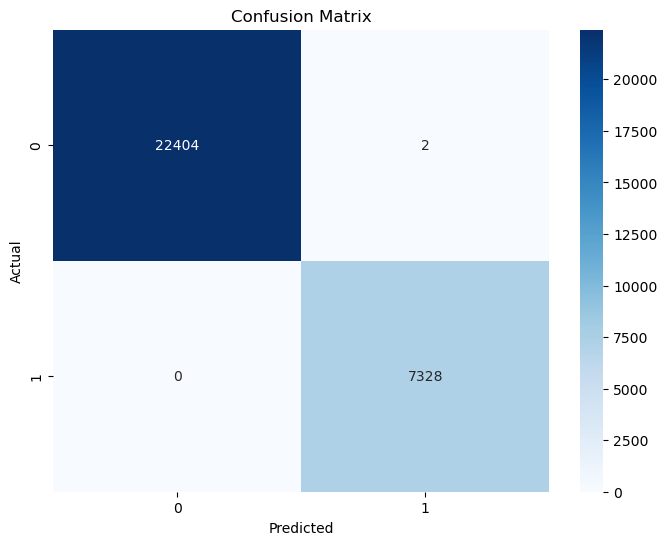

In [30]:
y_pred_proba = best_xgb.predict_proba(X_val)[:, 1]
y_pred = best_xgb.predict(X_val)

auc_score = roc_auc_score(y_val, y_pred_proba)
f1 = f1_score(y_val, y_pred)

print(f"AUC Score: {auc_score:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_val, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Best threshold: 0.420
Best F1 score: 0.9999


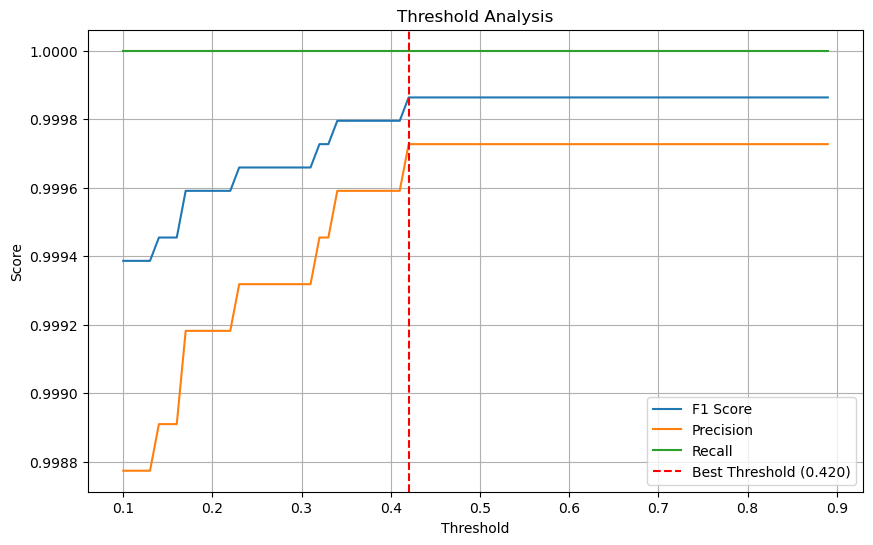

In [31]:
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    f1_thresh = f1_score(y_val, y_pred_thresh)
    precision_thresh = precision_score(y_val, y_pred_thresh)
    recall_thresh = recall_score(y_val, y_pred_thresh)
    
    f1_scores.append(f1_thresh)
    precision_scores.append(precision_thresh)
    recall_scores.append(recall_thresh)

best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print(f"Best threshold: {best_threshold:.3f}")
print(f"Best F1 score: {best_f1:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold ({best_threshold:.3f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Analysis')
plt.legend()
plt.grid(True)
plt.show()

y_pred_optimized = (y_pred_proba >= best_threshold).astype(int)

#### The AUC & F1 score are suspeciously too perfect

In [20]:
correlations = X.corrwith(y).abs().sort_values(ascending=False)
print("Top 10 correlations with target:")
print(correlations.head(10))

# Look for correlations near 1.0 or 0.99+
suspicious_features = correlations[correlations > 0.5].index.tolist()
print(f"Suspicious features (correlation > 0.5): {suspicious_features}")

Top 10 correlations with target:
credit_type_EQUI                     0.592168
lump_sum_payment_not_lpsm            0.187752
Neg_ammortization_not_neg            0.155835
co-applicant_credit_type_EXP         0.144239
credit_type_CRIF                     0.126332
credit_type_EXP                      0.124660
submission_of_application_to_inst    0.122410
Upfront_charges                      0.095094
loan_type_type2                      0.092550
business_or_commercial_nob/c         0.092550
dtype: float64
Suspicious features (correlation > 0.5): ['credit_type_EQUI']


## Data leakage alert

AUC = 1.0000 and F1 = 0.9999 are too good to be true for a real-world loan default prediction problem. This typically indicates data leakage - where future information is inadvertently included in training features.

POST-VERIFICATION FEATURES (After Decision/During Loan Structuring)
Loan Pricing & Terms ⚠️ HIGHLY LEAKY
rate_of_interest - Final interest rate (set based on risk assessment)

Interest_rate_spread - Risk-based pricing spread (directly tied to approval decision)

Upfront_charges - Fees determined based on risk level

term - Final loan term (can vary based on risk)

Loan Structure Details ⚠️ LEAKY
Neg_ammortization - Negative amortization terms (set during loan structuring)

interest_only - Interest-only payment option (risk-based decision)

lump_sum_payment - Payment structure (determined during loan setup)

Final Calculated Ratios ⚠️ VERY LEAKY
LTV - Loan-to-Value ratio (calculated after final appraisal and loan amount)

dtir1 - Debt-to-Income ratio (calculated after income verification and final loan terms)

The model is trying to predict loan default risk (the outcome), but it's using features that are determined AFTER the risk assessment is made. This creates an impossible scenario where the model has access to "future" information that won't be available when making real predictions.

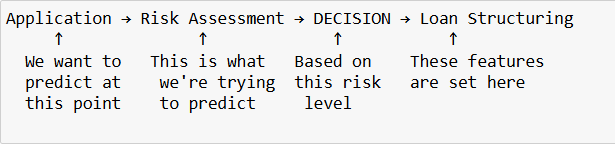

## reupdating the dataset to avoid leakage

In [21]:
leaky_features_to_remove = [
    'Interest_rate_spread',         
    'rate_of_interest',             
    'Upfront_charges',              
    'LTV',                          
    'dtir1',                        
    'term',                         
    'Neg_ammortization',           
    'interest_only',                
    'lump_sum_payment',             
    'credit_type',                  
    'co-applicant_credit_type',    
    'approv_in_adv',               
    'Credit_Worthiness',           
    'submission_of_application'     
]

### Only selecting features that are available before risk assessment

In [22]:
df = pd.read_csv(data_path)
df_clean = df.drop(columns=['ID'] + leaky_features_to_remove, errors='ignore')

safe_features = [
    # Demographics 
    'year', 'Gender', 'age', 'Region',
    
    # Loan request details 
    'loan_amount', 'loan_purpose', 'loan_type', 'loan_limit',
    
    # Financial information 
    'income', 'Credit_Score', 'open_credit', 'business_or_commercial',
    
    # Property information 
    'property_value', 'construction_type', 'occupancy_type', 
    'Secured_by', 'total_units', 'Security_Type'
]

available_safe_features = [f for f in safe_features if f in df_clean.columns]
X_safe = df_clean[available_safe_features]
y = df_clean['Status']

print(f"Using {len(available_safe_features)} safe features")
print(f"Safe dataset shape: {X_safe.shape}")

Using 18 safe features
Safe dataset shape: (148670, 18)


## Running Data preprocessing again

In [25]:
numerical_features = X_safe.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_safe.select_dtypes(include=['object']).columns.tolist()

df_processed = df_clean.copy()

# numerical features - use median imputation
numerical_imputer = SimpleImputer(strategy='median')
df_processed[numerical_features] = numerical_imputer.fit_transform(df_processed[numerical_features])

# categorical features - use mode imputation
categorical_imputer = SimpleImputer(strategy='most_frequent')
df_processed[categorical_features] = categorical_imputer.fit_transform(df_processed[categorical_features])

print(f"Missing values after imputation: {df_processed.isnull().sum().sum()}")

Missing values after imputation: 0


In [26]:
# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_processed, columns=categorical_features, drop_first=True)

print(f"Dataset shape after encoding: {df_encoded.shape}")
print(f"Features increased from {len(numerical_features) + len(categorical_features)} to {df_encoded.shape[1] - 1}")

# Display some of the new encoded columns
print("\nSample of encoded columns:")
print(df_encoded.columns[:20].tolist())

Dataset shape after encoding: (148670, 34)
Features increased from 18 to 33

Sample of encoded columns:
['year', 'loan_amount', 'property_value', 'income', 'Credit_Score', 'Status', 'Gender_Joint', 'Gender_Male', 'Gender_Sex Not Available', 'age_35-44', 'age_45-54', 'age_55-64', 'age_65-74', 'age_<25', 'age_>74', 'Region_North-East', 'Region_central', 'Region_south', 'loan_purpose_p2', 'loan_purpose_p3']


## Feature Selection

In [27]:
X = df_encoded.drop(target_column, axis=1)
y = df_encoded[target_column]

print(f"Total features before selection: {X.shape[1]}")

correlations = X.corrwith(y).abs()
high_corr_features = correlations[correlations > 0.1].index.tolist()

print(f"Features with correlation > 0.1: {len(high_corr_features)}")
print("\nTop 10 correlated features:")
print(correlations.sort_values(ascending=False).head(10))

Total features before selection: 33
Features with correlation > 0.1: 0

Top 10 correlated features:
loan_type_type2                 0.092550
business_or_commercial_nob/c    0.092550
property_value                  0.080905
Gender_Joint                    0.079030
income                          0.060618
Gender_Sex Not Available        0.053336
loan_limit_ncf                  0.053332
Region_south                    0.040051
loan_amount                     0.036825
loan_purpose_p4                 0.029602
dtype: float64


In [28]:
rf_baseline = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_baseline.fit(X, y)

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_baseline.feature_importances_
}).sort_values('importance', ascending=False)

top_important_features = feature_importance.head(20)['feature'].tolist()

print("Top 20 features by Random Forest importance:")
for i, feature in enumerate(top_important_features):
    print(f"{i+1}. {feature}: {feature_importance.iloc[i]['importance']:.4f}")

Top 20 features by Random Forest importance:
1. property_value: 0.3583
2. income: 0.1859
3. loan_amount: 0.1638
4. Credit_Score: 0.1634
5. loan_purpose_p3: 0.0095
6. age_45-54: 0.0091
7. Region_south: 0.0085
8. loan_purpose_p4: 0.0085
9. Gender_Male: 0.0084
10. age_55-64: 0.0083
11. loan_type_type3: 0.0074
12. age_35-44: 0.0071
13. age_65-74: 0.0069
14. loan_limit_ncf: 0.0066
15. Gender_Joint: 0.0065
16. Region_central: 0.0056
17. Gender_Sex Not Available: 0.0051
18. occupancy_type_pr: 0.0048
19. business_or_commercial_nob/c: 0.0041
20. age_>74: 0.0041


In [29]:
selected_features = list(set(high_corr_features + top_important_features))
print(f"Total selected features after combining methods: {len(selected_features)}")

X_selected = X[selected_features]
print(f"Final feature set shape: {X_selected.shape}")

print("\nSelected features:")
for i, feature in enumerate(selected_features):
    print(f"{i+1}. {feature}")

Total selected features after combining methods: 20
Final feature set shape: (148670, 20)

Selected features:
1. Gender_Joint
2. loan_type_type3
3. occupancy_type_pr
4. age_35-44
5. Region_central
6. Gender_Male
7. age_>74
8. age_45-54
9. Gender_Sex Not Available
10. property_value
11. income
12. loan_amount
13. loan_purpose_p3
14. loan_purpose_p4
15. age_65-74
16. age_55-64
17. Region_south
18. loan_limit_ncf
19. Credit_Score
20. business_or_commercial_nob/c


## Train-Validation Split

In [30]:
X_train, X_val, y_train, y_val = train_test_split(
    X_selected, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Training set default rate: {y_train.mean():.4f}")
print(f"Validation set default rate: {y_val.mean():.4f}")

Training set shape: (118936, 20)
Validation set shape: (29734, 20)
Training set default rate: 0.2464
Validation set default rate: 0.2465


## Class Imbalance handling using SMOTE

In [31]:
print("Class distribution before SMOTE:")
print(y_train.value_counts())

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"\nTraining set shape after SMOTE: {X_train_balanced.shape}")
print(f"Training set default rate after SMOTE: {y_train_balanced.mean():.4f}")
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

Class distribution before SMOTE:
Status
0    89625
1    29311
Name: count, dtype: int64

Training set shape after SMOTE: (179250, 20)
Training set default rate after SMOTE: 0.5000

Class distribution after SMOTE:
Status
0    89625
1    89625
Name: count, dtype: int64


## Model Training with Hyperparameter Tuning

In [32]:
xgb_model = xgb.XGBClassifier(
    tree_method='gpu_hist',
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 1.5, 2]
}

print("Hyperparameter grid defined")
print(f"Total parameter combinations: {np.prod([len(v) for v in param_grid.values()])}")

Hyperparameter grid defined
Total parameter combinations: 1458


In [33]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    xgb_model, 
    param_grid, 
    cv=cv, 
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_balanced, y_train_balanced)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation F1 score:", grid_search.best_score_)

Fitting 3 folds for each of 1458 candidates, totalling 4374 fits
Best parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0.5, 'reg_lambda': 1, 'subsample': 0.8}
Best cross-validation F1 score: 0.8751860779119656


In [34]:
best_xgb = xgb.XGBClassifier(
    **grid_search.best_params_,
    early_stopping_rounds=10,
    random_state=42,
    eval_metric='logloss',
    use_label_encoder=False
)

eval_set = [(X_train_balanced, y_train_balanced), (X_val, y_val)]
best_xgb.fit(
    X_train_balanced, y_train_balanced,
    eval_set=eval_set,
    verbose=False
)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

## Performance Evaluation

AUC Score: 0.8281
F1 Score: 0.6575

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.91     22406
           1       0.84      0.54      0.66      7328

    accuracy                           0.86     29734
   macro avg       0.85      0.75      0.79     29734
weighted avg       0.86      0.86      0.85     29734



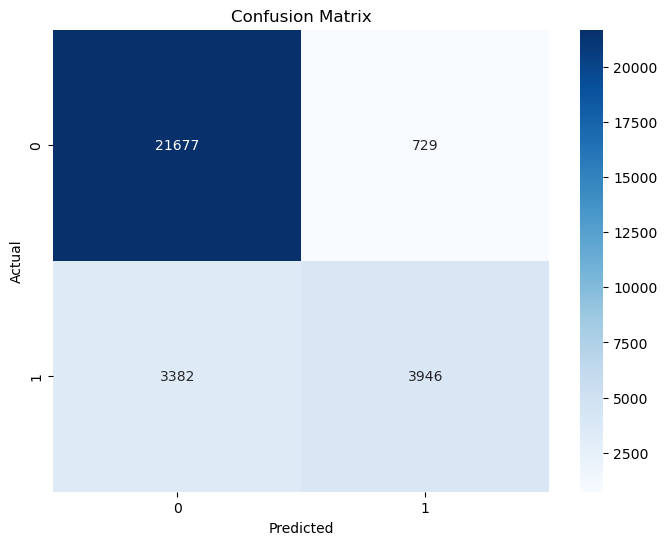

In [35]:
y_pred_proba = best_xgb.predict_proba(X_val)[:, 1]
y_pred = best_xgb.predict(X_val)

auc_score = roc_auc_score(y_val, y_pred_proba)
f1 = f1_score(y_val, y_pred)

print(f"AUC Score: {auc_score:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Decision Threshold Tuning

Best threshold: 0.470
Best F1 score: 0.6607


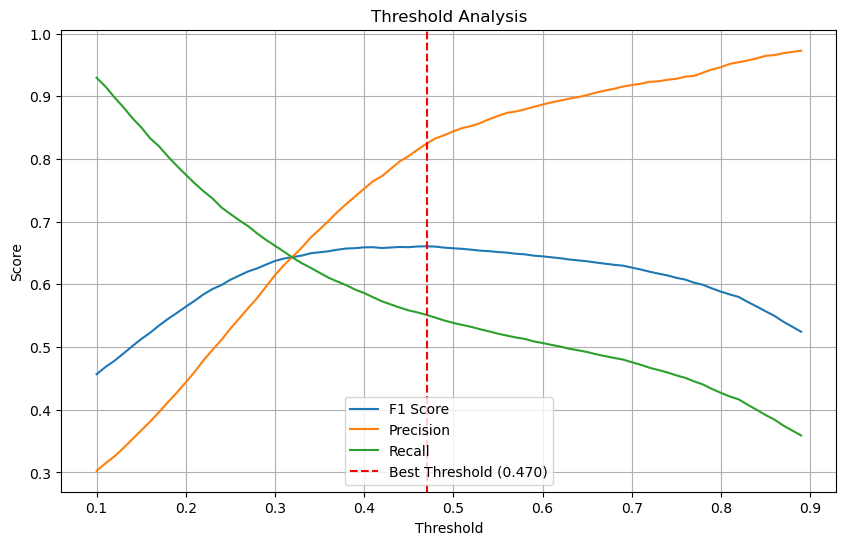

In [36]:
thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)
    f1_thresh = f1_score(y_val, y_pred_thresh)
    precision_thresh = precision_score(y_val, y_pred_thresh)
    recall_thresh = recall_score(y_val, y_pred_thresh)
    
    f1_scores.append(f1_thresh)
    precision_scores.append(precision_thresh)
    recall_scores.append(recall_thresh)

best_threshold_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_idx]
best_f1 = f1_scores[best_threshold_idx]

print(f"Best threshold: {best_threshold:.3f}")
print(f"Best F1 score: {best_f1:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.axvline(x=best_threshold, color='red', linestyle='--', label=f'Best Threshold ({best_threshold:.3f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Analysis')
plt.legend()
plt.grid(True)
plt.show()

y_pred_optimized = (y_pred_proba >= best_threshold).astype(int)

## SHAP for Model Explanation

In [37]:
explainer = shap.TreeExplainer(best_xgb)

shap_sample_size = min(1000, len(X_val))
X_val_sample = X_val.sample(n=shap_sample_size, random_state=42)
shap_values = explainer.shap_values(X_val_sample)

print(f"SHAP values calculated for {shap_sample_size} samples")

SHAP values calculated for 1000 samples


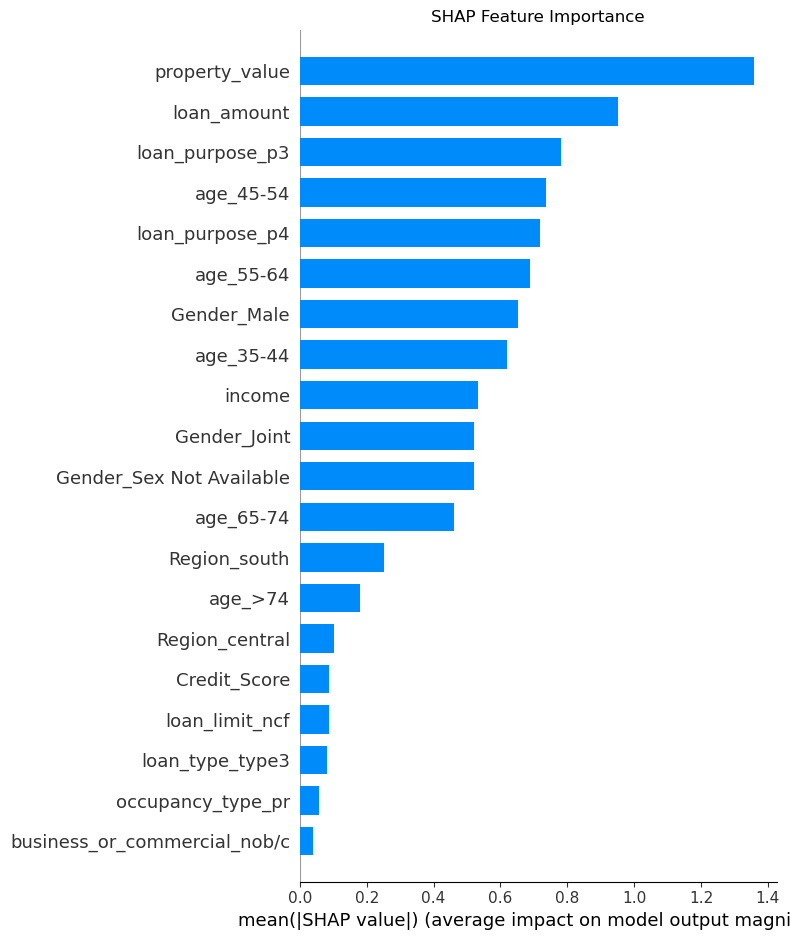

In [38]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_val_sample, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

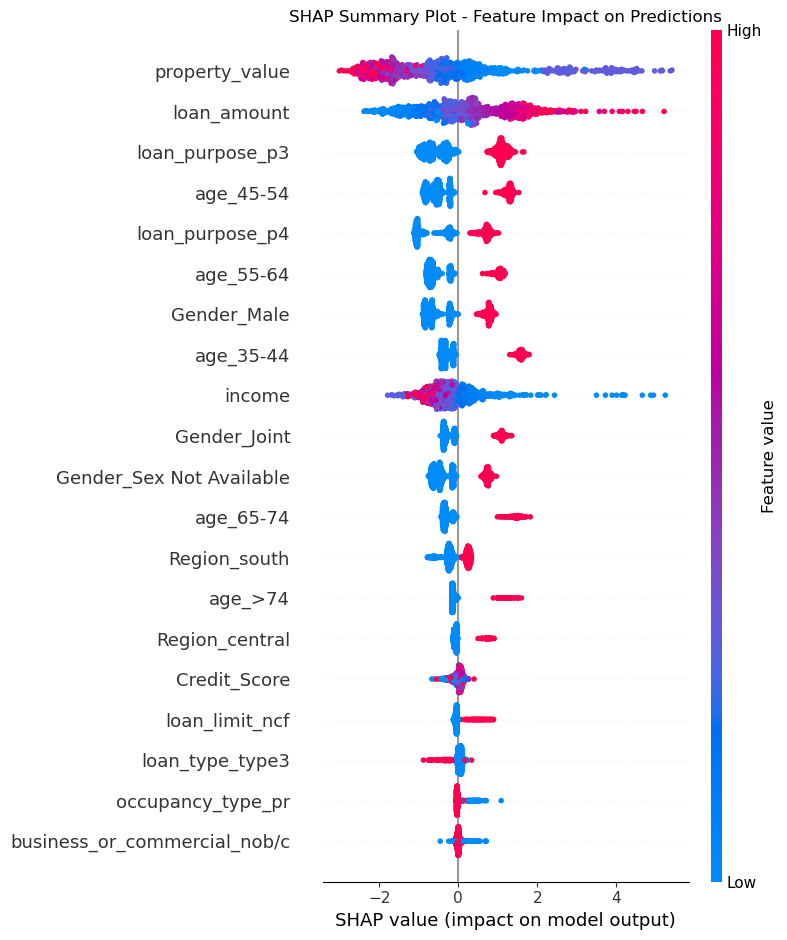

In [39]:
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_val_sample, show=False)
plt.title("SHAP Summary Plot - Feature Impact on Predictions")
plt.tight_layout()
plt.show()

### Feature Importance Analysis

Top 15 Most Important Features:
                     feature  importance
0               Gender_Joint    0.108317
13           loan_purpose_p4    0.092399
5                Gender_Male    0.086917
8   Gender_Sex Not Available    0.079782
3                  age_35-44    0.073257
9             property_value    0.071324
16              Region_south    0.068904
14                 age_65-74    0.060885
7                  age_45-54    0.060811
12           loan_purpose_p3    0.060689
15                 age_55-64    0.058442
17            loan_limit_ncf    0.046716
4             Region_central    0.046156
6                    age_>74    0.036925
10                    income    0.012467


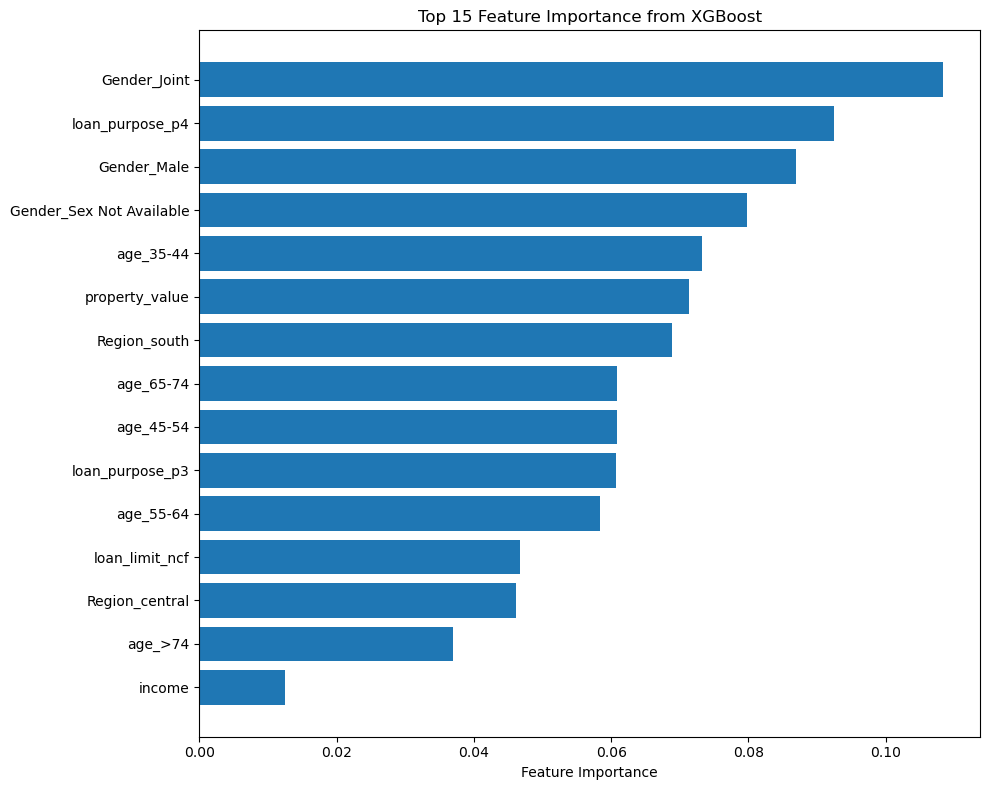

In [40]:
feature_importance_final = pd.DataFrame({
    'feature': X_selected.columns,
    'importance': best_xgb.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 15 Most Important Features:")
print(feature_importance_final.head(15))

plt.figure(figsize=(10, 8))
top_features = feature_importance_final.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Feature Importance from XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

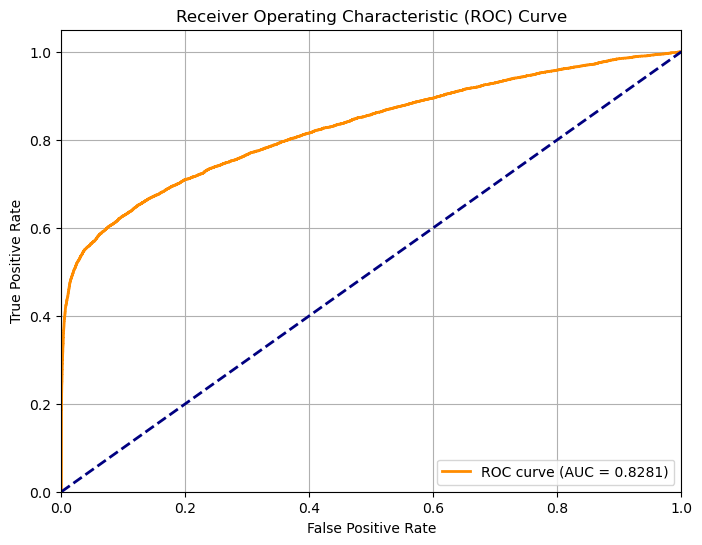

In [43]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_val, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [44]:
from sklearn.metrics import precision_score, recall_score

precision_opt = precision_score(y_val, y_pred_optimized)
recall_opt = recall_score(y_val, y_pred_optimized)
f1_opt = f1_score(y_val, y_pred_optimized)

print("="*60)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("="*60)
print(f"Model: XGBoost Classifier")
print(f"Total original features: {len(df.columns) - 1}")
print(f"Selected features: {len(selected_features)}")
print(f"Training samples: {X_train_balanced.shape[0]} (after SMOTE)")
print(f"Validation samples: {X_val.shape[0]}")
print(f"Class distribution (original): {y.value_counts().values}")
print(f"Default rate (original): {y.mean():.4f}")
print("-"*60)
print("PERFORMANCE METRICS:")
print(f"AUC Score: {auc_score:.4f}")
print(f"F1 Score (default threshold): {f1:.4f}")
print(f"F1 Score (optimized threshold): {f1_opt:.4f}")
print(f"Precision (optimized): {precision_opt:.4f}")
print(f"Recall (optimized): {recall_opt:.4f}")
print(f"Optimal threshold: {best_threshold:.3f}")
print("="*60)

FINAL MODEL PERFORMANCE SUMMARY
Model: XGBoost Classifier
Total original features: 33
Selected features: 20
Training samples: 179250 (after SMOTE)
Validation samples: 29734
Class distribution (original): [112031  36639]
Default rate (original): 0.2464
------------------------------------------------------------
PERFORMANCE METRICS:
AUC Score: 0.8281
F1 Score (default threshold): 0.6575
F1 Score (optimized threshold): 0.6607
Precision (optimized): 0.8243
Recall (optimized): 0.5513
Optimal threshold: 0.470


## Model Deployment

In [45]:
import joblib
import os

# Creating directory for model artifacts
model_dir = "model_artifacts"
os.makedirs(model_dir, exist_ok=True)

# Saving the trained model
joblib.dump(best_xgb, os.path.join(model_dir, 'loan_default_xgb_model.pkl'))

# Saving preprocessors
joblib.dump(numerical_imputer, os.path.join(model_dir, 'numerical_imputer.pkl'))
joblib.dump(categorical_imputer, os.path.join(model_dir, 'categorical_imputer.pkl'))

joblib.dump(selected_features, os.path.join(model_dir, 'selected_features.pkl'))
joblib.dump(best_threshold, os.path.join(model_dir, 'optimal_threshold.pkl'))
joblib.dump(numerical_features, os.path.join(model_dir, 'numerical_features.pkl'))
joblib.dump(categorical_features, os.path.join(model_dir, 'categorical_features.pkl'))

performance_metrics = {
    'auc_score': auc_score,
    'f1_score_optimized': f1_opt,
    'precision': precision_opt,
    'recall': recall_opt,
    'best_threshold': best_threshold
}
joblib.dump(performance_metrics, os.path.join(model_dir, 'performance_metrics.pkl'))

['model_artifacts\\performance_metrics.pkl']

In [46]:
def predict_loan_default(new_data, model_dir='model_artifacts'):
    """
    Complete prediction pipeline for new loan applications
    
    Parameters:
    new_data: DataFrame with same structure as training data
    model_dir: Directory containing saved model artifacts
    
    Returns:
    predictions: Binary predictions (0/1)
    probabilities: Prediction probabilities
    """
    
    # Loading saved components
    model = joblib.load(os.path.join(model_dir, 'loan_default_xgb_model.pkl'))
    num_imputer = joblib.load(os.path.join(model_dir, 'numerical_imputer.pkl'))
    cat_imputer = joblib.load(os.path.join(model_dir, 'categorical_imputer.pkl'))
    selected_features = joblib.load(os.path.join(model_dir, 'selected_features.pkl'))
    threshold = joblib.load(os.path.join(model_dir, 'optimal_threshold.pkl'))
    numerical_features = joblib.load(os.path.join(model_dir, 'numerical_features.pkl'))
    categorical_features = joblib.load(os.path.join(model_dir, 'categorical_features.pkl'))
    
    # Preprocess new data
    new_data_processed = new_data.copy()
   
    if 'ID' in new_data_processed.columns:
        new_data_processed = new_data_processed.drop('ID', axis=1)
    
    new_data_processed[numerical_features] = num_imputer.transform(new_data_processed[numerical_features])
    new_data_processed[categorical_features] = cat_imputer.transform(new_data_processed[categorical_features])
    
    new_data_encoded = pd.get_dummies(new_data_processed, columns=categorical_features, drop_first=True)
    
    for feature in selected_features:
        if feature not in new_data_encoded.columns:
            new_data_encoded[feature] = 0
    
    new_data_final = new_data_encoded[selected_features]
    
    probabilities = model.predict_proba(new_data_final)[:, 1]
    predictions = (probabilities >= threshold).astype(int)
    
    return predictions, probabilities

print("Prediction pipeline created successfully")

Prediction pipeline created successfully
